# <center>Big Data For Engineers&ndash; Solutions</center>
## <center>Spring 2025 &ndash; Week 1 &ndash; ETH Zurich</center>

### Aims
- **After this exercise:** Understand the SQL language and its common query patterns.
- **Later in the semester:** Relate these language features and query patterns relative to other data shapes, technologies, and the languages designed to query them.



- **After this exercise:** Understand the 'table' data shape, normalization, and when they can (and should) be used.
- **Later in the semester:** Understand when you can (and should) throw all of this away!

### Prerequisites
In this exercise, you will brush-up the fundamental concepts of relational databases and SQL. If you haven't taken an introductory databases course (or want to refresh your knowledge) we recommend you to read the following:

Garcia-Molina, Ullman, Widom: Database Systems: The Complete Book. Pearson, 2. Edition, 2008. (Chapters 1, 2, 3, and 6) [Available in the ETH Library] [[Online]](https://ebookcentral.proquest.com/lib/ethz/detail.action?pq-origsite=primo&docID=5832965) [[Selected solutions]](http://infolab.stanford.edu/~ullman/dscbsols/sols.html)

### Database Set-up

Unlike last week's exercise, the dataset for this exercise might take a little bit longer to download and initialize. Please wait for the message `PostgreSQL init process complete; ready for start up` in the terminal before proceeding!

As before, we set up our connection to the database and enable use of `%sql` and `%%sql`.

In [1]:
%reload_ext sql
%sql postgresql://postgres:example@db:5432/postgres

Connecting to 'postgresql://postgres:***@db:5432/postgres'

In [2]:
%%sql
SELECT version();

Running query in 'postgresql://postgres:***@db:5432/postgres'

1 rows affected.

version
"PostgreSQL 17.0 (Debian 17.0-1.pgdg120+1) on aarch64-unknown-linux-gnu, compiled by gcc (Debian 12.2.0-14) 12.2.0, 64-bit"


## Exercise 1: Explore the dataset
We want to first understand the dataset a bit better. You will find some queries below to help you explore the schema. In the process, consider the following questions:

1. Which concepts are modelled in the dataset and how do they relate to each other?
2. The data is stored as tables. Why was this shape chosen and why not the other shapes?
3. In which normal forms are the corresponding relations?
4. What are the efficiency trade-offs from adding an `artist_id` and `artist_name` directly to the `releases` table? Hints:
   - What are some typical queries that would benefit from this change?
   - How often do we need to update artists?
5. What potential problems could result from adding this redundancy?

### Where we got the data from
- [Discogs](https://www.discogs.com/)
- [Discogs XML data dumps](http://data.discogs.com/)
- [Download the dataset](https://cloud.inf.ethz.ch/s/4bZWo4TjeXgCNz5) (only necessary if you don't want to use Docker, see `postgres-init.sh` to see how to import it)

### List tables
The following query retrieves a list of tables in the database from a system table describing the current database.

In [3]:
%%sql 
SELECT table_name
FROM information_schema.tables
WHERE table_schema = 'public';

Running query in 'postgresql://postgres:***@db:5432/postgres'

22 rows affected.

table_name
companies
jobs
employees02
badges
comments
inventory
posthistory
postlinks
posts
tags


### List attributes/columns
The following query retrieves a list of columns from the tables in the database.

In [4]:
%%sql 
SELECT table_name, column_name, data_type, is_nullable, ordinal_position
FROM information_schema.columns
WHERE table_schema = 'public' AND table_name IN ('artists', 'released_by', 'releases', 'tracks')
AND table_name NOT LIKE 'pg_%'
ORDER BY table_name, ordinal_position;

Running query in 'postgresql://postgres:***@db:5432/postgres'

17 rows affected.

table_name,column_name,data_type,is_nullable,ordinal_position
artists,artist_id,integer,NO,1
artists,name,character varying,YES,2
artists,realname,text,YES,3
artists,profile,text,YES,4
artists,url,text,YES,5
released_by,release_id,integer,NO,1
released_by,artist_id,integer,NO,2
releases,release_id,integer,NO,1
releases,released,date,NO,2
releases,title,text,NO,3


### Exercise 1: Solution
1. Which concepts are modelled in the dataset and how do they relate to each other?

   The dataset contains data from `discogs` and models musical artists, their physical releases, and the tracks on those releases.

2. The data is stored as tables. Why was this shape chosen and why not the other shapes?
   - The number of concepts is limited, fixed, and well-defined.
   - The same is true for attributes of these concepts.
   - Attributes come from a well-defined domains with a fixed semantic (such as dates, e-mail addresses, ...).
   - Instances of concepts are in relation with each other, which may or may not be required to exist.
   - In short: we can define a schema, which the rest of the application (the website) relies on.


3. In which normal forms are the corresponding relations?

   - All relations are atomic so they are in 1NF.
   - `artists` and `releases` both have a singular ID primary key, so they at least 2NF. Upon inspection, there are no transitive dependencies, so they are in 3NF.
   - `released_by` does not contain non-key attributes, so it is in 3NF.
   - `tracks` has a foreign key constraint but no primary key constraint (although this is not captured by normal forms). The reason is likely because the data is crowd-sourced and archival, and there could be duplicate entries in the database.


4. What are the efficiency trade-offs from adding an `artist_id` and `artist_name` directly to the `releases` table? Hints:

   - What are some typical queries that would benefit from this change?
   - How often do we need to update artists?
   
   A very typical query is finding all the releases by an artist's name. If we redundantly store the artist's ID and name in `releases`, the aforementioned query now only requires a `SELECT` instead of an expensive `JOIN`. As releases can be released by multiple artists, we could also extend this idea and break 1NF by storing a list of artist names instead. The tradeoff here is that every time we have to update an artist's name we have to find and update all releases by that artist. Considering that reads are very common and changes are rare, the option of denormalizing becomes relatively more attractive.

5. What potential problems could result from denormalizing the data?

   - Insert anomaly: we could insert a release with a fake or incorrect artist name.
   - Update anomaly: if we update an artist's name but not all of the records in `releases`, we introduce an inconsistency into the dataset.

## Exercise 2: SQL warm-up
Let us begin with several SQL queries to ease us back into the language.

1. Retrieve all artists with the name of 'Madonna'.

In [7]:
%%sql
SELECT * FROM artists WHERE name = 'Madonna';

Running query in 'postgresql://postgres:***@db:5432/postgres'

1 rows affected.

artist_id,name,realname,profile,url
8760,Madonna,Madonna Louise Veronica Ciccone,"American singer, entertainer, songwriter, actress, director and businesswoman. Madonna achieved popularity by pushing the boundaries of lyrical content in mainstream popular music and imagery in her music videos. Referred to as the ""Queen of Pop"", Madonna is often cited as an influence by other artists. Born August 16, 1958 in Bay City, Michigan, Madonna moved to New York City to pursue a career in modern dance. After performing in the music groups [a=Breakfast Club] and [url=http://www.discogs.com/artist/Emmy+(7)]Emmy[/url], she signed with Sire in 1982 and released her debut album, [i][m=5319][/i], the following year. She followed it with a series of commercially successful albums, has sold more than 300 million records worldwide and is recognized as the best-selling female recording artist of all time by Guinness World Records. Madonna was inducted into the Rock and Roll Hall of Fame in her first year of eligibility. She was ranked at number one on VH1's list of 100 Greatest Women in Music, and at number two on Billboard's list of Greatest Hot 100 Artists of All Time (behind only The Beatles), the latter making her the most successful solo artist in the history of American singles chart.",http://www.madonna.com


2. List the titles of all releases by that artist in alphabetical order.

In [8]:
%%sql
SELECT DISTINCT releases.title
FROM artists
JOIN released_by USING(artist_id)
JOIN releases USING(release_id)
WHERE artists.name = 'Madonna'
ORDER BY releases.title;

Running query in 'postgresql://postgres:***@db:5432/postgres'

200 rows affected.

title
Accapella - Limited Edition Album
American Life
American Life / Die Another Day
American Life (The Remixes)
American Pie
Angel
Angel (Extended Dance Mix)
Bad Girl
Beautiful Stranger
"Beautiful Stranger (Music From The Motion Picture Austin Powers ""The Spy Who Shagged Me"")"


3. List the titles of all releases by that artist that contain less than 5 tracks.

In [9]:
%%sql
SELECT releases.title, COUNT(*) AS num_tracks
FROM artists
JOIN released_by USING(artist_id)
JOIN releases USING(release_id)
JOIN tracks USING(release_id)
WHERE artists.name = 'Madonna'
GROUP BY releases.release_id, releases.title
HAVING COUNT(*) < 5;

Running query in 'postgresql://postgres:***@db:5432/postgres'

426 rows affected.

title,num_tracks
Nothing Really Matters,3
Music,4
Bedtime Story,4
Music,4
What It Feels Like For A Girl,4
What It Feels Like For A Girl,4
American Pie,4
Like A Prayer,3
The Power Of Good-Bye,4
Human Nature,4


4. What are the top 10 artists with the most releases?

In [10]:
%%sql
SELECT artists.artist_id, artists.name, COUNT(*) AS num_releases
FROM artists
JOIN released_by USING(artist_id)
JOIN releases USING(release_id)
GROUP BY artists.artist_id, artists.name
ORDER BY num_releases DESC
LIMIT 10;

Running query in 'postgresql://postgres:***@db:5432/postgres'

10 rows affected.

artist_id,name,num_releases
194,Various Artists,46123
8760,Madonna,617
7552,Pet Shop Boys,600
4118,Faithless,336
15885,Michael Jackson,332
10343,Tangerine Dream,295
1280,Underworld,273
8024,Janet Jackson,249
7142,The Art Of Noise,238
1279,Orbital,236


5. How many artists have more releases than the average number of releases per artists (who have at least 1 release)

In [11]:
%%sql

SELECT COUNT(*)
FROM (
    SELECT COUNT(*) AS release_count
    FROM artists
    JOIN released_by USING(artist_id)
    JOIN releases USING(release_id)
    GROUP BY artists.artist_id) releases_per_artist
WHERE release_count > 
            (SELECT AVG(release_count)
             FROM
               (SELECT COUNT(*) AS release_count
                FROM artists
                JOIN released_by USING(artist_id)
                JOIN releases USING(release_id)
                GROUP BY artists.artist_id) releases_per_artist)

Running query in 'postgresql://postgres:***@db:5432/postgres'

1 rows affected.

count
6568


6. What are the names and IDs of the artists that have both a release with the genre 'Pop' *and* a release with the genre 'Classical'? Give a query that uses `INTERSECT` and one that uses `EXISTS`.

In [12]:
%%sql
SELECT artists.artist_id, artists.name
FROM artists
JOIN released_by USING(artist_id)
JOIN releases USING(release_id)
WHERE releases.genre = 'Pop'
INTERSECT
SELECT artists.artist_id, artists.name
FROM artists
JOIN released_by USING(artist_id)
JOIN releases USING(release_id)
WHERE releases.genre = 'Classical'

Running query in 'postgresql://postgres:***@db:5432/postgres'

5 rows affected.

artist_id,name
273394,John Williams (4)
15900,Ennio Morricone
59756,Sarah Brightman
208267,Jerry Goldsmith
194,Various Artists


In [13]:
%%sql
SELECT a1.artist_id, a1.name
FROM artists a1
WHERE EXISTS (
    SELECT *
    FROM artists a2
    JOIN released_by USING(artist_id)
    JOIN releases USING(release_id)
    WHERE releases.genre = 'Pop'
    AND a1.artist_id = a2.artist_id
) AND EXISTS (
    SELECT *
    FROM artists a2
    JOIN released_by USING(artist_id)
    JOIN releases USING(release_id)
    WHERE releases.genre = 'Classical'
    AND a1.artist_id = a2.artist_id
)

Running query in 'postgresql://postgres:***@db:5432/postgres'

5 rows affected.

artist_id,name
208267,Jerry Goldsmith
15900,Ennio Morricone
59756,Sarah Brightman
194,Various Artists
273394,John Williams (4)


## Exercise 3: Impact of release genre on average track duration and track count
For this exercise, we want to find out how average track duration and track count varies across genres.

To start, write a query which finds all of the distinct genres:

In [14]:
%%sql
SELECT DISTINCT genre
FROM releases;

Running query in 'postgresql://postgres:***@db:5432/postgres'

15 rows affected.

genre
Blues
Brass & Military
Children's
Classical
Electronic
"Folk, World, & Country"
Funk / Soul
Hip Hop
Jazz
Latin


Take a guess as to which genre has:
1. The highest average track count?
2. The lowest average track count?
3. The longest average track duration?
4. The shortest average track duration?

Next, write a query to calculate the average track count per genre:

In [15]:
%%sql 
SELECT tracks_per_release.genre, AVG(tracks_per_release.track_count) AS avg_track_count
FROM 
    (SELECT releases.genre, COUNT(*) AS track_count
    FROM releases JOIN tracks USING(release_id)
    GROUP BY releases.release_id, releases.genre) tracks_per_release
GROUP BY tracks_per_release.genre
ORDER BY avg_track_count

Running query in 'postgresql://postgres:***@db:5432/postgres'

15 rows affected.

genre,avg_track_count
Funk / Soul,6.8075666848121938
Electronic,7.2625240795359316
Pop,8.3270622286541245
Hip Hop,8.9810341573881865
Classical,9.5642023346303502
Brass & Military,10.0000000000000000
Rock,10.0942363605267659
Reggae,10.1671490593342981
Non-Music,11.2124645892351275
Latin,11.7385620915032680


Write a query to calculate the average duration per genre. Your result should have two attributes: `genre` and `avg_duration`.

In [16]:
%%sql
SELECT releases.genre, AVG(tracks.duration) AS avg_duration
FROM releases JOIN tracks USING(release_id)
GROUP BY releases.genre
ORDER BY avg_duration

Running query in 'postgresql://postgres:***@db:5432/postgres'

15 rows affected.

genre,avg_duration
Children's,200.7361111111111111
Blues,232.7512562814070352
Stage & Screen,235.7117437722419929
Pop,254.8109141466805700
Rock,264.6603242913539249
Latin,266.9276169265033408
Brass & Military,270.1500000000000000
Hip Hop,278.2096741996827098
Reggae,281.9811401323749199
"Folk, World, & Country",284.0997566909975669


Did the results match what you expected? Copy your queries into the following python script to plot the result.

Running query in 'postgresql://postgres:***@db:5432/postgres'

15 rows affected.

["Children's", 'Blues', 'Stage & Screen', 'Pop', 'Rock', 'Latin', 'Brass & Military', 'Hip Hop', 'Reggae', 'Folk, World, & Country', 'Funk / Soul', 'Jazz', 'Non-Music', 'Electronic', 'Classical']
[Decimal('200.7361111111111111'), Decimal('232.7512562814070352'), Decimal('235.7117437722419929'), Decimal('254.8109141466805700'), Decimal('264.6603242913539249'), Decimal('266.9276169265033408'), Decimal('270.1500000000000000'), Decimal('278.2096741996827098'), Decimal('281.9811401323749199'), Decimal('284.0997566909975669'), Decimal('292.3742753188597017'), Decimal('299.3291493999568831'), Decimal('310.5186963112683173'), Decimal('338.7964461394944572'), Decimal('363.7217249796582587')]


Text(0, 0.5, 'Genre')

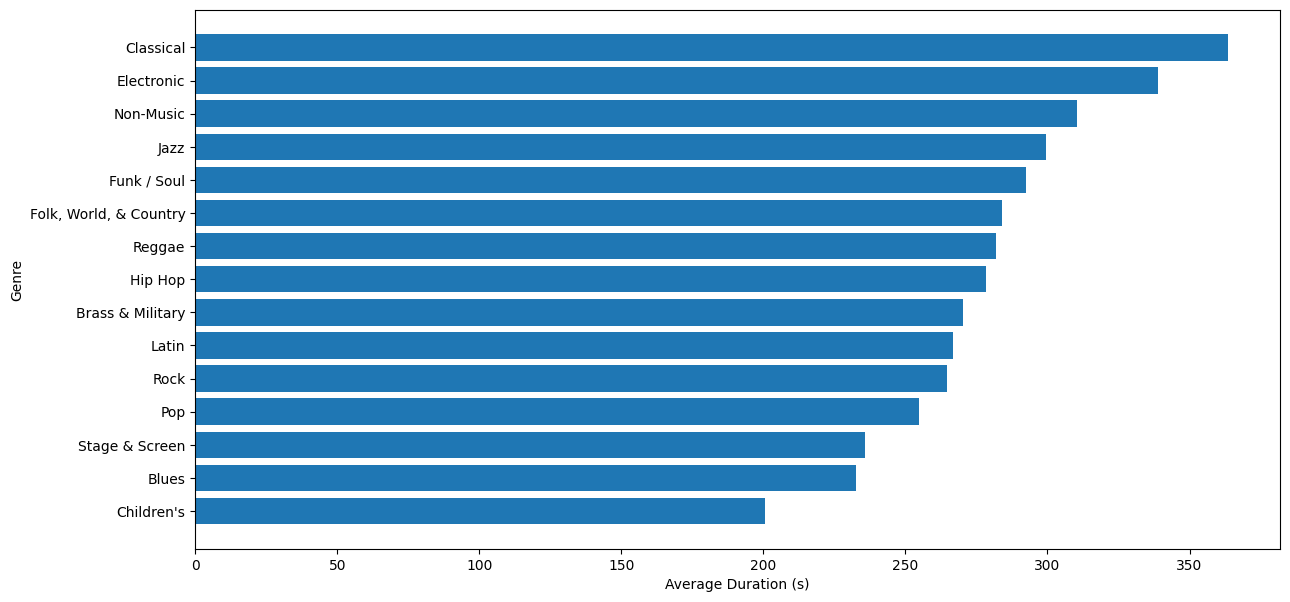

In [17]:
%matplotlib inline
import matplotlib.pyplot as plt

# Store the result of the query in a Python object (add your query here!)
result = %sql   SELECT releases.genre, AVG(tracks.duration) AS avg_duration \
                FROM releases JOIN tracks USING(release_id) \
                GROUP BY releases.genre \
                ORDER BY avg_duration ASC; \

# Convert the result to a Pandas data frame
df = result.DataFrame()

# Extract x and y values for a plot
x = df['genre'].tolist()
y = df['avg_duration'].tolist()

# Print them just for debugging
print(x)
print(y)

# Plot the distribution of scores
fig = plt.figure(figsize =(14, 7))
plt.barh(x, y, align='center')
plt.xlabel('Average Duration (s)')
plt.ylabel('Genre')

## Exercise 4: Discuss query patterns and language features of SQL
1. What patterns did you use in many of the queries above?

2. Do you remember the theory behind them?

3. What makes SQL a declarative language and what advantages does that have?

4. What makes SQL a functional language and what advantages does that have?

### Exercise 4: Solution
1. Most queries consist of the following basic operations. They will reoccur throughout the whole semester. Watch out for them!
  * **Select**: select a subset of the rows/data records/items.
  * **Project**: select a subset of the properties/ attributes/columns.
  * **Join**: bring two datasets together based on a common attribute.
  * **Group**: divide the items/ rows/records into groups and summarize each group with a single value.
  * **Order**: order the items according to some criteria.
  
2. Relational algebra operators formalize most of this (grouping is technically not part of the algebra).
  
3. We only describe *what* we want, not how this should be computed. We *declare* what our intent is. This shifts the implementation effort from the programmer to the database system. The hope is that the system has more information at hand, such as data size, data distribution, information about the hardware, in order to choose the best way to compute the result. This results into efficient computation with little effort from the programmer.
  
4. SQL is functional because results of a query can be used as input of another query, either in form of tables or in form of scalars. This makes SQL expressive.